In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.special

In [30]:
N = 16
K = 8

In [31]:
def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    
    return s

def inc_bin(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=int), np.ones(1,dtype=int)))
    a = add_bool(a,increment)
    return a

def approx(C):
    W = inv_fc(1-(1-pi_fc(C))**2)  
    return W

def pi_fc(x):
    a = -0.4527
    b = 0.0218
    r = 0.86
    
    if x < 10:
        P = np.exp(a*(x**r)+b)
    else:
        P = np.sqrt((np.pi)/x)*np.exp(-x/4)*(1-10/(7*x))
        
    return P

def inv_fc(x):
    a = -0.4527
    b = 0.0218
    r = 0.86
    
    I = ((np.log(x)-b)/a)**(1/r)
    
    return I
    

def polarization(N, K, sigma_train):
    
    W = np.ones(N, dtype=float)
    W_temp = np.zeros(N, dtype=float)
    
    W[0] = (2/(sigma_train**2))
    
    for i in range(1, int(np.log2(N))+1):
        W_temp[:] = W[:]
        t = 2**(i-1)
        
        for j in range(1,(int(t))+1):
            C = W_temp[j-1]
            W[2*j-1-1] = approx(C)         #polarization by using density evolution
            W[2*j-1] = 2*C
                  
    qfunc = lambda x: 0.5-0.5*scipy.special.erf(x/np.sqrt(2))
    W = qfunc(np.sqrt(W/2))
    idx = sorted(range(W.size), key=lambda k: -W[k]) # descend order 
    A = idx[-K:]

    
    return A
    
def encoding(u, N):

    n = 1
    x = np.copy(u)
    step = np.log2(N)
    for s in range(0,step.astype(int)):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
        
    for s in range(0,N):
        if np.mod(x[s],2) == 0:
            x[s] = 0

    return x

In [32]:
snr_train = 2
sigma_train = np.sqrt(1/(2*10**(snr_train/10)))
print(sigma_train)

0.561674881261


In [33]:
b = np.zeros((2**K,K),dtype=int)
for i in range(1,2**K):
    b[i]= inc_bin(b[i-1])

In [34]:
A = polarization(N, K, sigma_train)
u = np.zeros((2**K, N), dtype=int)
u[:,A] = b

In [35]:
A

[9, 10, 12, 7, 11, 13, 14, 15]

In [36]:
x = np.zeros((2**K, N), dtype=int)

for i in range(0, 2**K):
    x[i,:] = encoding(u[i,:], N)
    
x = (-1)**x # BPSK modulation

In [37]:
b[:,:]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ..., 
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [38]:
u[:,:]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ..., 
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 1]])

In [39]:
x[:,:]

array([[ 1,  1,  1, ...,  1,  1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1,  1, -1, ...,  1, -1,  1],
       ..., 
       [-1, -1,  1, ...,  1, -1, -1],
       [-1,  1,  1, ..., -1, -1,  1],
       [ 1, -1, -1, ...,  1,  1, -1]])

In [44]:
Layer1 = N
Layer2 = N
Layer3 = N
Layer4 = N


X = tf.placeholder(tf.float32,[None, N])
Y = tf.placeholder(tf.float32,[None, N])

#W1 = tf.Variable(tf.zeros([N, Layer1]))
#W2 = tf.Variable(tf.zeros([Layer1, Layer2]))
#W3 = tf.Variable(tf.zeros([Layer2, Layer3]))
#W4 = tf.Variable(tf.zeros([Layer3, N]))

W1 = tf.Variable(tf.random_uniform([N, Layer1], -1.0, 1.0))
W2 = tf.Variable(tf.random_uniform([Layer1, Layer2], -1.0, 1.0))
W3 = tf.Variable(tf.random_uniform([Layer2, Layer3], -1.0, 1.0))
W4 = tf.Variable(tf.random_uniform([Layer3, Layer4], -1.0, 1.0))
W5 = tf.Variable(tf.random_uniform([Layer4, N], -1.0, 1.0))

b1 = tf.Variable(tf.zeros([Layer1]), name = "Bias1")
b2 = tf.Variable(tf.zeros([Layer2]), name = "Bias2")
b3 = tf.Variable(tf.zeros([Layer3]), name = "Bias3")
b4 = tf.Variable(tf.zeros([Layer4]), name = "Bias4")
b5 = tf.Variable(tf.zeros([N]), name = "Bias4")

L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
hypo = tf.nn.sigmoid(tf.matmul(L4, W5) + b5)

#cost = -tf.reduce_mean(tf.maximum(Y,0)*tf.log(hypo)+tf.maximum(-Y,0)*tf.log(-hypo)+((1-tf.abs(Y))*tf.log(1-hypo)))
#cost = -tf.reduce_mean(tf.maximum(Y,0)*tf.log(hypo)+tf.maximum(-Y,0)*tf.log(-hypo)+((1-tf.abs(Y))*tf.log(1-hypo)))
#cost = -tf.reduce_mean(Y*tf.log(hypo)+(1-Y)*tf.log(1-hypo))
cost = tf.reduce_mean(tf.square(Y-hypo))

a = 0.05
optimizer = tf.train.GradientDescentOptimizer(a)
train = optimizer.minimize(cost)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [46]:
num_train = 6

trial = 51
num_snr = 8
error = np.zeros([num_train, num_snr], dtype="float")
BER = np.zeros([num_train, num_snr], dtype="float")

for t in range(num_train):

    for step in range(2**(2*t+20)):
        sess.run(train, feed_dict={X:x+np.random.normal(0,sigma_train,(2**K, N)), Y:u})

        if step % 10000 == 0:
            print(step)
            print(sess.run(cost, feed_dict={X:x+np.random.normal(0,sigma_train,(2**K, N)), Y:u})) 


    correct_detection = tf.equal(tf.round(hypo), Y)
    accuracy = tf.reduce_mean(tf.cast(correct_detection,"float"))        


    print("Accuracy:", sess.run(accuracy, feed_dict={X:x+np.random.normal(0,sigma_train,(2**K, N)), Y:u}))

    for snr in range(num_snr):

        sigma = np.sqrt(1/(2*10**(snr/10)))
        to = 0

        for i in range(trial):

            wrong_detection = tf.not_equal(tf.round(hypo), Y)
            num_error = tf.reduce_sum(tf.cast(wrong_detection,"float"))     

            e = sess.run(num_error, feed_dict={X:x+np.random.normal(0,sigma,(2**K, N)), Y:u})
            e = e#*(2**K)*N

            to = to + (2**K)*N
            error[t, snr] = error[t, snr] + e

            if i%10 == 0 and i != 0:
                print(snr, error[t, snr]/to)

        BER[t, snr] = error[t, snr]/to


0
0.311009
10000
0.273877
20000
0.25804
30000
0.251173
40000
0.221021
50000
0.202556
60000
0.185261
70000
0.1785
80000
0.175478
90000
0.17435
100000
0.171814
110000
0.171595
120000
0.168413
130000
0.170959
140000
0.170644
150000
0.167613
160000
0.16571
170000
0.166398
180000
0.16477
190000
0.165156
200000
0.163546


KeyboardInterrupt: 

In [27]:
BER

array([[ 0.24130668,  0.23934398,  0.23934398,  0.23808498,  0.23787914,
         0.2371515 ,  0.23652439,  0.23679247],
       [ 0.22054994,  0.21890319,  0.21730909,  0.21524108,  0.21339327,
         0.21350337,  0.2118997 ,  0.21055932],
       [ 0.19358437,  0.18911803,  0.18477137,  0.18115713,  0.17743279,
         0.17412971,  0.17192287,  0.17059685],
       [ 0.16784429,  0.16231522,  0.15743719,  0.1522145 ,  0.14918428,
         0.14725031,  0.14367436,  0.14309992],
       [ 0.12260168,  0.11194087,  0.10554056,  0.10004021,  0.09738339,
         0.0946021 ,  0.09333352,  0.09221814],
       [ 0.10925532,  0.10170133,  0.0966749 ,  0.09431009,  0.09216069,
         0.0906384 ,  0.09076287,  0.09051873]])

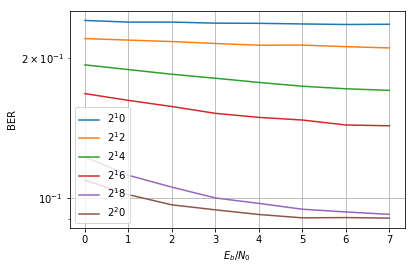

In [28]:
legend = []

plt.figure(1)

for t in range(num_train):
    plt.plot(range(num_snr), BER[t,:])
    legend.append('$2^{}$'.format(2*t+10)) 
 
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.show()

In [681]:
# trial = 500
# error_sum = 0



# for i in range(trial):

#     R = np.random.choice(2**K)
#     xx = x[R,:]
#     uu = u[R,:]

#     kr = np.ones((2**K,1),dtype="int")
#     x_test = np.kron(xx, kr)
#     u_test = np.kron(uu, kr)

#     FE = tf.not_equal(tf.round(hypo[R,:]), Y[R,:])
#     FER = tf.reduce_mean(tf.cast(FE,"float")) 

#     e = sess.run(FER, feed_dict={X:x_test+np.random.normal(0,sigma,(2**K, N)), Y:u_test})

#     if e == 0:
#         error = 0
#     else:
#         error = 1

#     error_sum = error_sum + error

#     if i%10 == 0 and i != 0:
#         print(i, error_sum/i)    